# Mango Classification

* Website: https://aidea-web.tw/topic/72f6ea6a-9300-445a-bedc-9e9f27d91b1c
* Forum : https://www.facebook.com/groups/184056976135023/

## Dataset : AICUP 2020 Mango sample data
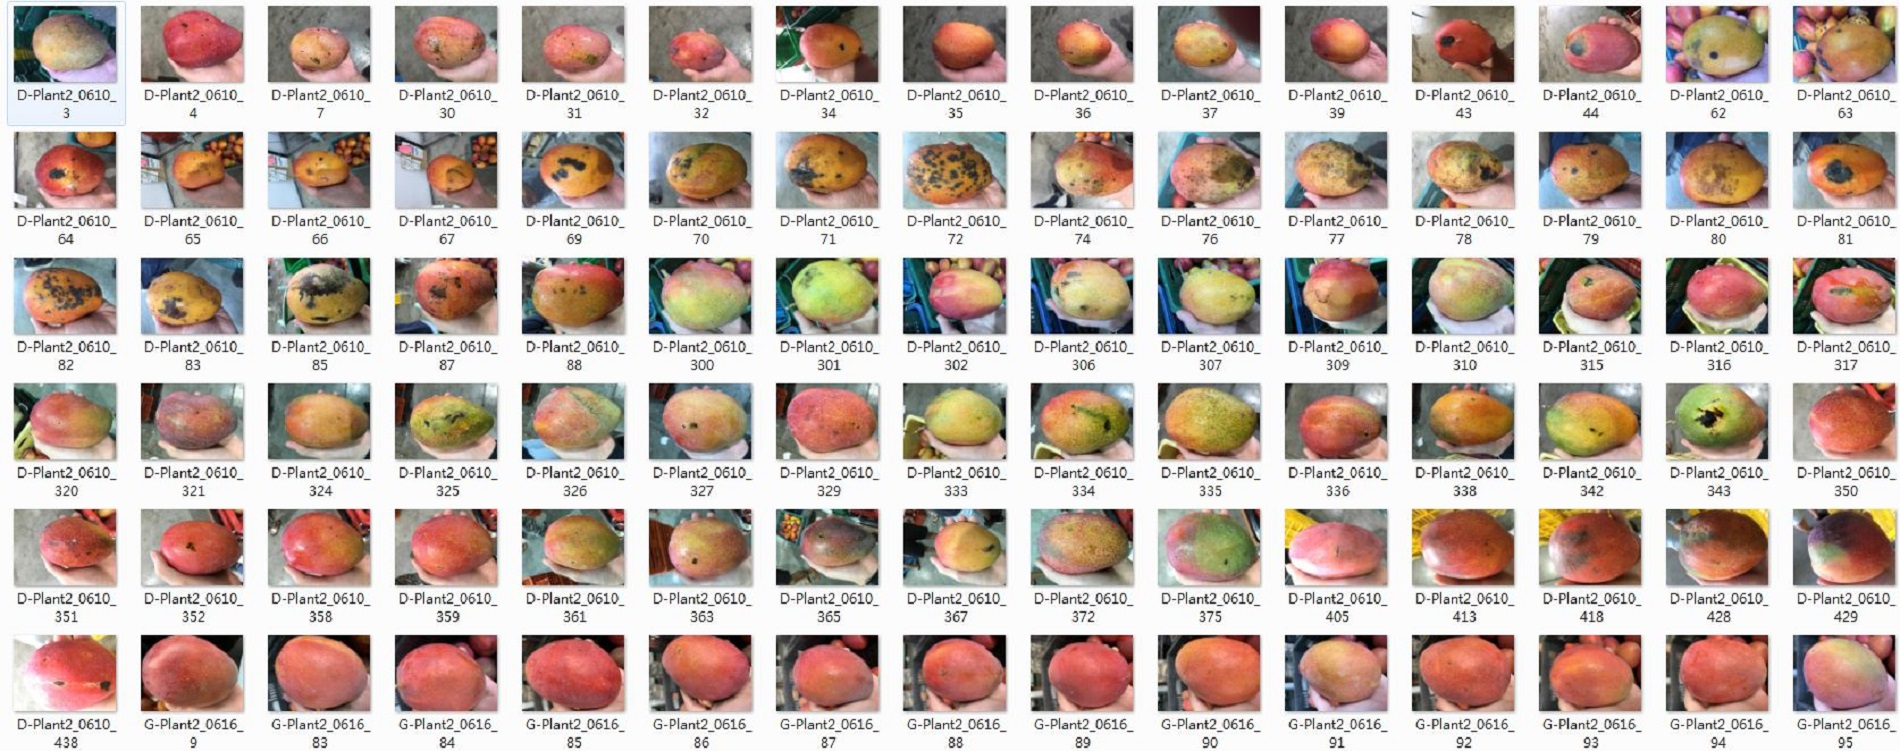

In [ ]:
import os
print(os.listdir('../input/aicup-2020-mango-c1-p1/C1-P1_Train Dev'))

In [ ]:
print(os.listdir('../input/aicup-2020-mango-c1-p1/C1-P1_Train Dev/C1-P1_Train'))

In [ ]:
trainPath = '../input/aicup-2020-mango-c1-p1/C1-P1_Train Dev/C1-P1_Train/'
devPath   = '../input/aicup-2020-mango-c1-p1/C1-P1_Train Dev/C1-P1_Dev/'

trainCSV = '../input/aicup-2020-mango-c1-p1/C1-P1_Train Dev/train.csv'
devCSV   = '../input/aicup-2020-mango-c1-p1/C1-P1_Train Dev/dev.csv'

In [ ]:
import pandas as pd
trainDF = pd.read_csv(trainCSV, header=None)
print(trainDF)

In [ ]:
trainFiles = trainDF[0].tolist()
trainClasses = trainDF[1].tolist()

In [ ]:
devDF = pd.read_csv(devCSV, header=None)
print(devDF)

In [ ]:
devFiles = devDF[0].tolist()
devClasses = devDF[1].tolist()

In [ ]:
labels = ['A', 'B', 'C']

## Dataset Equilibre 

In [ ]:
# plot the circle of value counts in dataset
import matplotlib.pyplot as plt

def plot_equilibre(equilibre, labels, title):
    plt.figure(figsize=(5,5))
    my_circle=plt.Circle( (0,0), 0.5, color='white')
    plt.pie(equilibre, labels=labels, colors=['red','green','blue'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(title)
    plt.show()

In [ ]:
equilibreTrain = []
[equilibreTrain.append(trainClasses.count(label)) for label in labels]
print(equilibreTrain)
plot_equilibre(equilibreTrain, labels, 'Train Data')
del equilibreTrain

In [ ]:
equilibreDev = []
[equilibreDev.append(devClasses.count(label)) for label in labels]
print(equilibreDev)
plot_equilibre(equilibreDev, labels, 'Development Data')
del equilibreDev

## Import Libraries

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical

from IPython.display import Image
import matplotlib.pyplot as plt

In [ ]:
TargetSize = (192, 144) # image ratio = 4:3
def prepare_image(filepath):
    img = cv2.imread(filepath)
    # get image height, width
    (h, w) = img.shape[:2]
    if (w<h): # rotate270
        # calculate the center of the image
        center = (w / 2, h / 2)
        M = cv2.getRotationMatrix2D(center, 270, 1.0)
        img = cv2.warpAffine(img, M, (h, w))
    img_resized = cv2.resize(img, TargetSize, interpolation=cv2.INTER_CUBIC)
    img_result  = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    return img_result

### Display Image file

In [ ]:
plt.imshow(prepare_image(trainPath+trainFiles[1]))

In [ ]:
plt.imshow(prepare_image(devPath+devFiles[1]))

## Prepare Data

### Training Data

In [ ]:
trainX = []
[trainX.append(prepare_image(trainPath+file)) for file in trainFiles]
trainX = np.asarray(trainX) 
print(trainX.shape)

# data normalisation
trainX = trainX / 255.0

In [ ]:
# Convert Y_data from {'A','B','C'} to {0,1,2}
trainY = []
[trainY.append(ord(trainClass) - 65) for trainClass in trainClasses]
#print(trainY)

# one-hot encoding
trainY = to_categorical(trainY)

### Development Data (for Validation)

In [ ]:
validX = []
[validX.append(prepare_image(devPath+file)) for file in devFiles]
validX = np.asarray(validX)    
print(validX.shape)

# data normalisation
validX = validX / 255.0

In [ ]:
# Convert Y_data from char to integer
validY = []
[validY.append(ord(devClass) - 65) for devClass in devClasses]
#print(validY)

# One-hot encoding
validY = to_categorical(validY)

### Shuffle Training Data

In [ ]:
from sklearn.utils import shuffle
trainX,trainY = shuffle(trainX,trainY, random_state=42)

In [ ]:
num_classes = 3

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, BatchNormalization, Activation, LeakyReLU, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## Build Model

In [ ]:
input_shape = trainX.shape[1:]
print(trainX.shape[1:])

In [ ]:
# Build Model

input_image = Input(shape=input_shape)
# 1st Conv layer
model = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_image)
model = MaxPooling2D((2, 2),padding='same')(model)
# 2nd Conv layer
model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 3rd Conv layer
model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 4th Conv layer
model = Conv2D(128, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 5th Conv layer
model = Conv2D(256, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# FC layers
model = Flatten()(model)

#model = Dense(1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
model = Dense(1024)(model)
#model = Dropout(0.2)(model)

#model = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
model = Dense(64)(model)
#model = Dropout(0.2)(model)

output= Dense(num_classes, activation='softmax')(model)

model = Model(inputs=[input_image], outputs=[output])

model.summary()

In [ ]:
# Compile Model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## set Checkpoint : save best only, verbose on
#checkpoint = ModelCheckpoint("mango_classification.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1)

## Train Model

In [ ]:
batch_size = 16
num_epochs = 80

In [ ]:
# Train Model
history = model.fit(trainX,trainY,batch_size=batch_size,epochs=num_epochs, validation_data=(validX,validY)) #, callbacks=[checkpoint])

## Save Model

In [ ]:
## Save Model
model.save('mango_cnn.h5')

In [ ]:
## load best model weights if using callback (save-best-only)
#model.load_weights("mango_classification.hdf5")

## Evaluate Model

### predict Validation set for a Confusion Matrix

In [ ]:
predY = model.predict(validX)
y_pred = np.argmax(predY,axis=1)
y_actual = np.argmax(validY,axis=1)
#y_label= [labels[k] for k in y_pred]
cm = confusion_matrix(y_actual, y_pred)
print(cm)

### plot confusion matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()        

In [ ]:
plot_confusion_matrix(cm, 
                      normalize=False,
                      target_names = labels,
                      title="Confusion Matrix, not Normalized")

In [ ]:
print(classification_report(y_actual, y_pred, target_names=labels))

## Test Model

### try a test image

In [ ]:
testPath  = '../input/aicup-2020-mango-c1-p1/C1-P1_Test/C1-P1_Test/'
testFiles = os.listdir(testPath)
testFiles.sort()
print(testFiles)

In [ ]:
testFile = '07497.jpg'
print(testPath+testFile)

In [ ]:
plt.imshow(prepare_image(testPath+testFile))

In [ ]:
testData = prepare_image(testPath+testFile).reshape(1,144,192,3)
testData = testData / 255.0
print(testData.shape)
predictions = model.predict(testData)
print(predictions[0])

In [ ]:
maxindex = int(np.argmax(predictions[0]))
print('Predicted: %s, Probability = %f' %(labels[maxindex], predictions[0][maxindex]) )

### prepare Test data

In [ ]:
testX = []
[testX.append(prepare_image(testPath+file)) for file in testFiles]
testX = np.asarray(testX)    
print(testX.shape)
testX = testX/255.0

### model prediction

In [ ]:
testY = model.predict(testX)
print(testY[0])

In [ ]:
# create a list of the predicted label
pred_y = []
for y in testY:
    maxindex = int(np.argmax(y))
    pred_y.append(labels[maxindex])
print(pred_y)

## Generate Submission

In [ ]:
# create dataframe with each image id & its predicted label
dfTest = pd.DataFrame(columns = ['image_id','label'])
dfTest['image_id'] = testFiles
dfTest['label']=pred_y

# output a .csv file
dfTest.to_csv('test_submission.csv',index=False)

# Versions
> V1. VGG16 transfer learning, accuracy : train = 100.00%, valid = 67.00% <br />
> V2. VGG19 transfer learning, accuracy : train = 100.00%, valid = 65.38% <br />
> V3. ResNet50V2             , accuracy : train =  99.43%, valid = 63.88% <br />
> V4. ResNet101V2            , accuracy : train =  99.39%, valid = 70.00% <br />
> V5. ResNet152V2            , accuracy : train =  99.41%, valid = 72.50% <br />
> V6. DenseNet121            , accuracy : train =  99.30%, valid = 72.62% <br />
> V7. EfficientNet B7        , accuracy : train =  99.61%, valid = 75.50% (epochs=150) <br />
> V8. CNNx5+FCx2             , accuracy : train =  98.75%, valid = 73.37% (epochs=100) <br />
> V9. CNNx5+FCx2 train+dev          , accuracy : train =  99.28%, valid = 99.12% (epochs=80) <br />
> V10.CNNx5+FCx2 dropout=0.2@FCs    , accuracy : train =  98.20%, valid = 73.00% (epochs=80) <br />
> V11.CNNx5+FCx2 dropout=0.1@Conv2Ds, accuracy : train =  95.98%, valid = 71.38% (epochs=100) <br />
> V12.CNNx4+FCx2             , accuracy : train = 100.00%, valid = 71.75% (epochs=50) <br />
> V12.CNNx4+FCx2             , accuracy : train = 100.00%, valid = 71.75% (epochs=50) <br />
> V13.CNNx5+FCx2 (1024+64)   , accuracy : train = 100.00%, valid = 73.25% (epochs=60) <br />
> V14.CNNx5+FCx2 (l2_regularizer, dropout), accuracy : train =  96.54%, valid = 70.75% (epochs=60) <br />
> V15.CNNx5+FCx2 (1024+64)   , accuracy : train = 98.29%, valid = 72.75% (epochs=80) <br />